In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from Batch import Batch
from data_gen import data_gen
from model_seq2seq import Seq2SeqModel
from model_generator import Generator
from simple_loss_compute import SimpleLossCompute
from run_epoch import run_epoch
from print_examples import print_examples
from iclib.core import init_seed, pt_init, pt_use_cuda, pt_device
from iclib.print_info import set_print, toggle_print, p_hb, p_he, p_ti

from torchtext import data, datasets
import spacy

In [4]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)

In [17]:
pt_init()
#pt_init(use_gpu=False)
print("CUDA:", pt_use_cuda())
print("DEVICE:", pt_device())

init_seed(42)
set_print(False)


CUDA: True
DEVICE: cuda:0


In [7]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]


In [8]:
def print_data_info(train_data, valid_data, test_data, src_field, trg_field):
    """ This prints some useful stuff about our data sets. """

    print("Data set sizes (number of sentence pairs):")
    print('train', len(train_data))
    print('valid', len(valid_data))
    print('test', len(test_data), "\n")

    print("First training example:")
    print("src:", " ".join(vars(train_data[0])['src']))
    print("trg:", " ".join(vars(train_data[0])['trg']), "\n")

    print("Most common words (src):")
    print("\n".join(["%10s %10d" % x for x in src_field.vocab.freqs.most_common(10)]), "\n")
    print("Most common words (trg):")
    print("\n".join(["%10s %10d" % x for x in trg_field.vocab.freqs.most_common(10)]), "\n")

    print("First 10 words (src):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(src_field.vocab.itos[:10])), "\n")
    print("First 10 words (trg):")
    print("\n".join(
        '%02d %s' % (i, t) for i, t in enumerate(trg_field.vocab.itos[:10])), "\n")

    print("Number of German words (types):", len(src_field.vocab))
    print("Number of English words (types):", len(trg_field.vocab), "\n")

In [9]:
def rebatch(pad_idx, batch):
    """Wrap torchtext batch into our own Batch class for pre-processing"""
    return Batch(batch.src, batch.trg, pad_idx)

In [11]:
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"    
SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
LOWER = True

# we include lengths to provide to the RNNs
SRC = data.Field(tokenize=tokenize_de, 
                 batch_first=True, lower=LOWER, include_lengths=True,
                 unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=None, eos_token=EOS_TOKEN)
TRG = data.Field(tokenize=tokenize_en, 
                 batch_first=True, lower=LOWER, include_lengths=True,
                 unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, init_token=SOS_TOKEN, eos_token=EOS_TOKEN)

MAX_LEN = 25  # NOTE: we filter out a lot of sentences for speed
train_data, valid_data, test_data = datasets.IWSLT.splits(
    exts=('.de', '.en'), fields=(SRC, TRG), 
    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 5  # NOTE: we limit the vocabulary to frequent words for speed
SRC.build_vocab(train_data.src, min_freq=MIN_FREQ)
TRG.build_vocab(train_data.trg, min_freq=MIN_FREQ)
    
PAD_INDEX = TRG.vocab.stoi[PAD_TOKEN]

In [12]:
print_data_info(train_data, valid_data, test_data, SRC, TRG)

Data set sizes (number of sentence pairs):
train 143116
valid 690
test 963 

First training example:
src: david gallo : das ist bill lange . ich bin dave gallo .
trg: david gallo : this is bill lange . i 'm dave gallo . 

Most common words (src):
         .     138325
         ,     105944
       und      41839
       die      40809
       das      33324
       sie      33035
       ich      31153
       ist      31035
        es      27449
       wir      25817 

Most common words (trg):
         .     137259
         ,      91619
       the      73344
       and      50273
        to      42798
         a      39573
        of      39496
         i      33524
        it      32921
      that      32643 

First 10 words (src):
00 <unk>
01 <pad>
02 </s>
03 .
04 ,
05 und
06 die
07 das
08 sie
09 ich 

First 10 words (trg):
00 <unk>
01 <pad>
02 <s>
03 </s>
04 .
05 ,
06 the
07 and
08 to
09 a 

Number of German words (types): 15761
Number of English words (types): 13003 



In [14]:
train_iter = data.BucketIterator(train_data, batch_size=64, train=True, 
                                 sort_within_batch=True, 
                                 sort_key=lambda x: (len(x.src), len(x.trg)), repeat=False,
                                 device=pt_device())
valid_iter = data.Iterator(valid_data, batch_size=1, train=False, sort=False, repeat=False, 
                           device=pt_device())

In [18]:
Vs = len(SRC.vocab)
Vt = len(TRG.vocab)
E = 256
H = 256
L = 1
dropout=0.2

lr=0.0003
print_every=100

model = Seq2SeqModel(Vs, Vt, E, E, H, L, dropout, Generator(H, Vt))
if pt_use_cuda():
    model.cuda(pt_device())
    
criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
optim = torch.optim.Adam(model.parameters(), lr=lr)

dev_perplexities = []


In [21]:
mpath = Path('.')/'models'

for epoch in range(10):
    print("Epoch %d" % epoch)
    model.train()
    run_epoch((rebatch(PAD_INDEX, b) for b in train_iter), 
              model, SimpleLossCompute(model.generator, criterion, optim), print_every=print_every)
    
    model.eval()
    with torch.no_grad(): 
        print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=3, src_vocab=SRC.vocab, trg_vocab=TRG.vocab)        

        dev_perplexity = run_epoch((rebatch(PAD_INDEX, b) for b in valid_iter), 
                                       model, 
                                       SimpleLossCompute(model.generator, criterion, None))
        print("Validation perplexity: %f" % dev_perplexity)
        dev_perplexities.append(dev_perplexity)
        
        #mfile = mpath/f'de-en-trans-task.pth-{epoch}'
        #torch.save(model.state_dict(), mfile)

mfile = mpath/'de-en-trans-task.pth'
torch.save(model.state_dict(), mfile)

Epoch 0
Epoch Step: 100 Loss: 14.555441 Tokens per Sec: 26400.116053
Epoch Step: 200 Loss: 101.337227 Tokens per Sec: 26429.283250
Epoch Step: 300 Loss: 25.553289 Tokens per Sec: 26846.771013
Epoch Step: 400 Loss: 85.731422 Tokens per Sec: 26801.431006
Epoch Step: 500 Loss: 40.868401 Tokens per Sec: 26562.451268
Epoch Step: 600 Loss: 38.950787 Tokens per Sec: 26703.626247
Epoch Step: 700 Loss: 101.915741 Tokens per Sec: 26775.444644
Epoch Step: 800 Loss: 105.231644 Tokens per Sec: 26747.190714
Epoch Step: 900 Loss: 33.671410 Tokens per Sec: 26668.076857
Epoch Step: 1000 Loss: 75.869713 Tokens per Sec: 26255.632681
Epoch Step: 1100 Loss: 109.312073 Tokens per Sec: 26517.122609
Epoch Step: 1200 Loss: 76.700005 Tokens per Sec: 27030.055759
Epoch Step: 1300 Loss: 71.037125 Tokens per Sec: 27091.202376
Epoch Step: 1400 Loss: 28.032452 Tokens per Sec: 26432.123295
Epoch Step: 1500 Loss: 35.978996 Tokens per Sec: 25909.152480
Epoch Step: 1600 Loss: 59.478058 Tokens per Sec: 26748.856571
Epoch

Example #3
Src :  er sah sehr glücklich aus , was damals ziemlich ungewöhnlich war , da ihn die nachrichten meistens <unk> .
Trg :  there was a big smile on his face which was unusual then , because the news mostly depressed him .
Pred:  he looked very happy , what was pretty much , and he was the <unk> to <unk> the news .

Validation perplexity: 13.930233
Epoch 4
Epoch Step: 100 Loss: 43.464630 Tokens per Sec: 25706.334840
Epoch Step: 200 Loss: 33.499287 Tokens per Sec: 26835.350015
Epoch Step: 300 Loss: 59.188469 Tokens per Sec: 26950.677089
Epoch Step: 400 Loss: 61.002441 Tokens per Sec: 26906.814062
Epoch Step: 500 Loss: 35.533924 Tokens per Sec: 26742.721270
Epoch Step: 600 Loss: 12.945827 Tokens per Sec: 26789.609596
Epoch Step: 700 Loss: 25.883720 Tokens per Sec: 26967.805200
Epoch Step: 800 Loss: 38.157066 Tokens per Sec: 26854.720429
Epoch Step: 900 Loss: 14.314346 Tokens per Sec: 26647.657480
Epoch Step: 1000 Loss: 37.209507 Tokens per Sec: 26615.144060
Epoch Step: 1100 Loss:

Epoch Step: 1900 Loss: 40.171597 Tokens per Sec: 26299.454028
Epoch Step: 2000 Loss: 54.483505 Tokens per Sec: 26954.603110
Epoch Step: 2100 Loss: 39.235950 Tokens per Sec: 27493.054904
Epoch Step: 2200 Loss: 21.875202 Tokens per Sec: 26653.546668

Example #1
Src :  als ich 11 jahre alt war , wurde ich eines morgens von den <unk> heller freude geweckt .
Trg :  when i was 11 , i remember waking up one morning to the sound of joy in my house .
Pred:  when i was 11 years old , i was one of the <unk> of the joy of joy .

Example #2
Src :  mein vater hörte sich auf seinem kleinen , grauen radio die <unk> der bbc an .
Trg :  my father was listening to bbc news on his small , gray radio .
Pred:  my father had focused on his little , <unk> radio shack the <unk> of the bbc .

Example #3
Src :  er sah sehr glücklich aus , was damals ziemlich ungewöhnlich war , da ihn die nachrichten meistens <unk> .
Trg :  there was a big smile on his face which was unusual then , because the news mostly depress

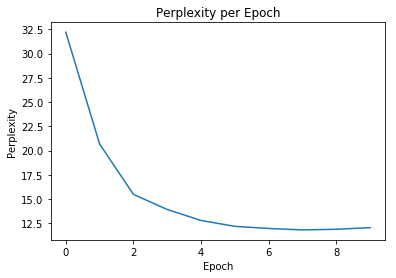

In [22]:
plot_perplexity(dev_perplexities)

In [23]:
print_examples((rebatch(PAD_INDEX, x) for x in valid_iter), 
                           model, n=100, src_vocab=SRC.vocab, trg_vocab=TRG.vocab) 


Example #1
Src :  als ich 11 jahre alt war , wurde ich eines morgens von den <unk> heller freude geweckt .
Trg :  when i was 11 , i remember waking up one morning to the sound of joy in my house .
Pred:  when i was 11 years old , i was a forger of the <unk> <unk> delight .

Example #2
Src :  mein vater hörte sich auf seinem kleinen , grauen radio die <unk> der bbc an .
Trg :  my father was listening to bbc news on his small , gray radio .
Pred:  my dad listened to his little , <unk> radio radio <unk> of the bbc .

Example #3
Src :  er sah sehr glücklich aus , was damals ziemlich ungewöhnlich war , da ihn die nachrichten meistens <unk> .
Trg :  there was a big smile on his face which was unusual then , because the news mostly depressed him .
Pred:  he looked very happy to see what was unusual at the time , because it was the most innovative most <unk> .

Example #4
Src :  er rief : " die taliban sind weg ! "
Trg :  " the taliban are gone ! " my father <unk> .
Pred:  he called " the tal

Example #38
Src :  heute jedoch drücken in afghanistan über drei millionen mädchen die <unk> .
Trg :  but today , more than three million girls are in school in afghanistan .
Pred:  but in the three days , we have three million girls who are <unk> .

Example #39
Src :  afghanistan erscheint , von amerika aus betrachtet , so anders .
Trg :  afghanistan looks so different from here in america .
Pred:  afghanistan is from the <unk> , from this .

Example #40
Src :  die amerikaner erkennen , wie unsicher solche veränderungen sind .
Trg :  i find that americans see the <unk> in changes .
Pred:  the americans who are the fundamental technologies such changes .

Example #41
Src :  ich befürchte , dass die veränderungen nicht von dauer sind und sich mit dem abzug der <unk> wieder alles ändert .
Trg :  i fear that these changes will not last much beyond the u.s. troops ' <unk> .
Pred:  i 'm saying that changes the change are not working from the <unk> and over the trigger of the <unk> back .

E

Example #74
Src :  man erreicht niemals eine gemeinde mit ideen , man setzt sich mit den <unk> zusammen .
Trg :  you never arrive in a community with any ideas , and you sit with the local people .
Pred:  you never have a community with ideas , you 're going to <unk> together .

Example #75
Src :  wir arbeiten nicht von büros aus .
Trg :  we do n't work from offices .
Pred:  we do n't work from offices .

Example #76
Src :  wir treffen uns in <unk> . wir treffen uns in <unk> .
Trg :  we meet at the cafe . we meet at the pub .
Pred:  we 're in <unk> . we meeting in <unk> .

Example #77
Src :  wir haben keine infrastruktur .
Trg :  we have zero infrastructure .
Pred:  we have no infrastructure .

Example #78
Src :  wir schließen freundschaften und finden heraus , was die person möchte .
Trg :  and what we do , we become friends , and we find out what that person wants to do .
Pred:  we close them and find out what the person would want .

Example #79
Src :  das wichtigste ist die leidens